In [5]:
# -------------------------------
# Prerequisite for most tutorials
# -------------------------------

# Here are a few helpers and dependencies that may be required by some tutorials:

%matplotlib inline
import os.path
from math import *
import numpy as np
from tramway.helper import *
from tramway.helper.simulation import *
import matplotlib.pylab as plt

trajectory_file = 'trajectories.txt'
rwa_file = 'trajectories.rwa'

trajectories_with_time_varying_properties = 'trajectories2.txt'
analyses_with_time_varying_properties = 'trajectories2.rwa'

def load_default_trajectories(time_varying_properties=False):
    if time_varying_properties:
        # trajectories2.txt
        if os.path.exists(trajectories_with_time_varying_properties):
            xyt = load_xyt(trajectories_with_time_varying_properties)
        else:
            x0 = y0 = 0.
            width = height = 1.
            duration = 5. # minimum duration of the simulation in s
            tau = .2 # trajectory lifetime in s
            D = .1 # diffusivity in um2.s-1
            dV = 10 # maximum force amplitude in kB.T(?)
            v_area_center= np.array([x0+width/2, y0+height/2, duration/2])
            v_area_radius = .2
            sigma = 1. / sqrt(-log(.05))
            time_factor = max(width, height) / duration *.8
            def F(r, t):
                f = r - v_area_center[:2]
                r2 = np.dot(f, f) + (time_factor * (t - v_area_center[2])) ** 2
                s2 = (v_area_radius * sigma) ** 2
                f *= -2. * dV / s2 * exp(-r2/s2)
                return f
            xyt = random_walk(diffusivity=D,
                force=F,
                lifetime_tau=tau,
                box=(x0, y0, x0+width, y0+height),
                duration=duration,
                minor_step_count=999,
                full=True,
                )
            t0 = .05 # dt
            xyt = xyt[xyt['t']<t0+duration]
            xyt.to_csv(trajectories_with_time_varying_properties, sep='\t', header=False)
        return xyt
    
    else:
        # trajectories.txt
        if os.path.exists(trajectory_file):
            xyt = load_xyt(trajectory_file)
        else:
            dt = .05 # time step in s
            tau = .25 # trajectory lifetime in s
            D = .1 # diffusivity in um2.s-1
            F = 2 # force amplitude in kB.T
            xyt = random_walk_2d(
                n_trajs=400, N_mean=tau/dt, dt=dt,
                D0=D, amplitude_D=0,
                amplitude_V=-F, mode_V='potential_linear',
                )
            xyt.to_csv(trajectory_file, sep='\t', header=False)
        return xyt

def load_default_partition(time_varying_properties=False):
    if time_varying_properties:
        # trajectories2.rwa
        if os.path.exists(analyses_with_time_varying_properties):
            analysis_tree = load_rwa(analyses_with_time_varying_properties, lazy=True)
        else:
            analysis_tree = Analyses(load_default_trajectories(time_varying_properties=True))
        if 'default' in analysis_tree.labels:
            cells = analysis_tree['default'].data
        else:
            cells = tessellate(analysis_tree, 'hexagon',
                lower_bound=np.array((-.1,-.1)), upper_bound=np.array((1.1,1.1)),
                time_window_duration=1., time_window_shift=1.,
                time_window_options=dict(time_dimension=True),
                knn=10,
                output_label='default')
            save_rwa(analyses_with_time_varying_properties, analysis_tree, force=True)
        return cells
    
    else:
        # trajectories.rwa
        if os.path.exists(rwa_file):
            analysis_tree = load_rwa(rwa_file, lazy=True)
        else:
            analysis_tree = Analyses(load_default_trajectories())
        if 'default' in analysis_tree.labels:
            cells = analysis_tree['default'].data
        else:
            cells = tessellate(analysis_tree, 'hexagon',
                lower_bound=np.array((-.6,-.6)), upper_bound=np.array((.6,.6)),
                output_label='default')
            save_rwa(rwa_file, analysis_tree, force=True)
        return cells

def load_default_maps(_and_partition=False):
    if os.path.exists(rwa_file):
        analysis_tree = load_rwa(rwa_file, lazy=True)
        if 'default' not in analysis_tree.labels:
            raise NotImplementedError('please run load_default_partition or delete the {} file'.format(rwa_file))
        if _and_partition:
            cells = analysis_tree['default'].data
    else:
        cells = load_default_partition()
        analysis_tree = Analyses(cells.points)
        analysis_tree.add(cells, label='default')
    default_subtree = analysis_tree['default']
    if 'default' not in default_subtree.labels:
        infer(analysis_tree, 'DV', localization_error=.01, input_label='default', output_label='default')
        save_rwa(rwa_file, analysis_tree, force=True)
    maps = default_subtree['default'].data
    if _and_partition:
        return maps, cells
    else:
        return maps
    
def load_default_tree(time_varying_properties=False):
    if time_varying_properties:
        _file = analyses_with_time_varying_properties
    else:
        _file = rwa_file
    if not os.path.exists(rwa_file):
        load_default_partition(time_varying_properties=time_varying_properties)
    return load_rwa(rwa_file, lazy=True)


0.0
0.25
0.5
0.75
1.0


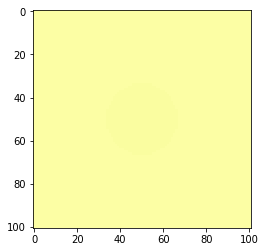

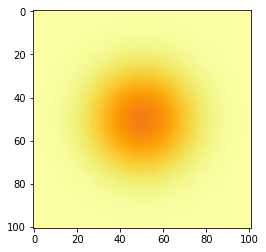

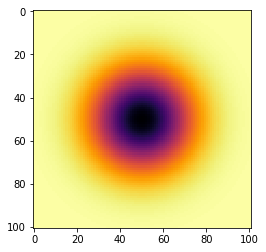

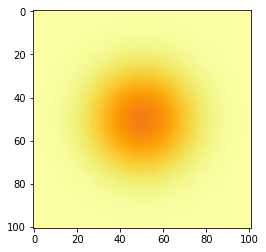

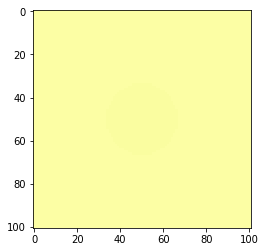

In [6]:
def D_field_array(r,t):
    mu_r=np.array([0.5,0.5])
    sig_r=0.05
    mu_t=0.5
    sig_t=0.05
    return 1.-1.*np.exp(-np.sum((r-mu_r)**2,axis=2)/sig_r)*np.exp(-(t-mu_t)**2/(sig_t))

def D_field(r,t):
    mu_r=np.array([0.5,0.5])
    sig_r=0.05
    mu_t=0.5
    sig_t=0.05
    return 1.-1.*np.exp(-np.sum((r-mu_r)**2)/sig_r)*np.exp(-(t-mu_t)**2/(sig_t))

M=100
x = np.arange(0,1.+1./M,1./M)
r = np.zeros([M+1,M+1,2])
for i,y_ in enumerate(x):
    r[i] = np.transpose(np.stack([y_*np.ones(M+1),x]))
for t in [0.,0.25,0.5,0.75,1.]:
    print(t)
    plt.figure()
    plt.imshow(D_field_array(r,t),clim=[0.,1.],cmap='inferno')

In [7]:
# --------------------------------------------------------
# Generating molecule trajectories with a diffusivity sink
# --------------------------------------------------------

## key parameters
# number of trajectories
number_of_trajectories = 100
# time step in s
dt = 0.05
# average trajectory lifetime in s
tau = 1.
# baseline diffusivity in um2.s-1
D0 = 0.1
# diffusivity at the bottom of the sink
D = 0.05
# positioning noise (optional)
sigma = 1e-4

## generate the trajectories
xyt = random_walk(diffusivity=D_field, duration=10.0, lifetime_tau=tau, single=True, reflect=True, trajectory_mean_count=10)
# see also:
# help(random_walk_2d)

# xyt is a DataFrame with columns 'x', 'y' (spatial coordinates), 't' (time) and 'n' (trajectory index).
# each row in a molecule location
#xyt

TypeError: random_walk() got an unexpected keyword argument 'reflect'

In [3]:
t=[]
for n in set(xyt['n']):
#     print(xyt[xyt['n']==n])
    t.append(len(xyt[xyt['n']==n]))
print((np.average(t)-1)*dt)

NameError: name 'xyt' is not defined

In [131]:
dt

0.05

In [5]:
# -----------------------------------------------------------------
# Generating molecule trajectories with a potential energy gradient
# -----------------------------------------------------------------

## key parameters
# number of trajectories
number_of_trajectories = 400
# time step in s
dt = 0.05
# average trajectory lifetime in s
tau = 0.25
# diffusivity
D = 0.1
# potential energy slope in kB.T
dV = 2
# positionning noise (optional)
sigma = 1e-4

## generate the trajectories
xyt = random_walk_2d(
        n_trajs=number_of_trajectories, N_mean=tau/dt, dt=dt,
        D0=D, amplitude_V=dV, mode_V='potential_linear',
        sigma_noise=sigma,
        )
# see also:
# help(random_walk_2d)

# xyt is a DataFrame with columns 'x', 'y' (spatial coordinates), 't' (time) and 'n' (trajectory index).
# each row in a molecule location
xyt

,n,x,y,t
0,1,-0.067327,0.199472,0.50
1,1,0.025184,0.124057,0.55
2,1,-0.009904,0.253500,0.60
3,1,0.120397,0.194430,0.65
4,1,0.059843,0.247392,0.70
5,1,-0.009011,0.277476,0.75
6,1,-0.074365,0.204759,0.80
7,1,-0.118161,0.176162,0.85
8,1,-0.178228,0.161967,0.90
9,1,-0.178084,0.100916,0.95


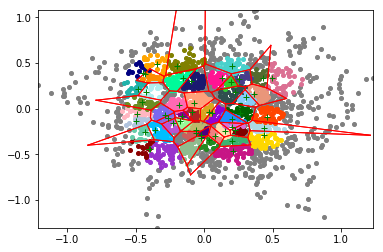

In [6]:
# ----------------------------------------------------------
# sampling random cell centers and associating knn locations
# ----------------------------------------------------------

## key parameters
number_of_cells = 50
number_of_locations_per_cell = 50 # both min and max

## load the translocation data
xyt = load_default_trajectories()
# explicit bounds are recommended here with box-less data generation
lower_bound, upper_bound = np.array((-0.5,-0.5)), np.array((0.5,0.5))

## tessellate
cells = tessellate(xyt, 'random', cell_count=number_of_cells,
        lower_bound=lower_bound, upper_bound=upper_bound,
        # knn defines the minimum and maximum number of neighbours
        knn=(number_of_locations_per_cell, number_of_locations_per_cell))
# see also command-line help:
# tramway tessellate random -h

## plot
cell_plot(cells)

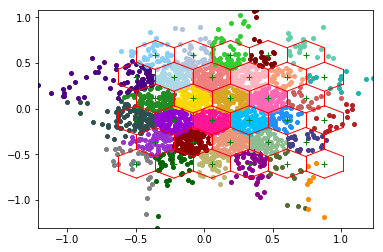

In [7]:
# -------------------------------------------
# tessellating with constant-size space cells
# -------------------------------------------

## key parameters
# average inter-cell distance or cell "diameter" in um
cell_size = 0.1

## load the translocation data
xyt = load_default_trajectories()
# explicit bounds are recommended here with box-less data generation
lower_bound, upper_bound = np.array((-0.6,-0.6)), np.array((0.6,0.6))

## tessellate
cells = tessellate(xyt, 'hexagon',
        # the inter-cell distance is 2*ref_distance
        ref_distance=cell_size/2,
        # discard the criterion on the minimum number of locations per cell
        min_location_count=None,
        lower_bound=lower_bound, upper_bound=upper_bound)
# see also command-line help:
# tramway tessellate hexagon -h

## plot
cell_plot(cells)

In [7]:
# ---------------------------------------------------------------------
# tessellating with approximately the same number of locations per cell
# ---------------------------------------------------------------------

# WARNING! This takes time.

## key parameters
# average number of locations per cell
location_count = 100
# relative margin on the number of locations per cell
count_margin = 0.1 # 10%

## load the translocation data
xyt = load_default_trajectories()

## tessellate
cells = tessellate(xyt, 'kohonen', avg_location_count=location_count,
        # use knn to control the range of variation in the location count
        knn=(round(location_count*(1.-count_margin)), round(location_count*(1.+count_margin))))
# see also command-line help:
# tramway tessellate kohonen -h

## plot
cell_plot(cells)

KeyboardInterrupt: 

segment: 1


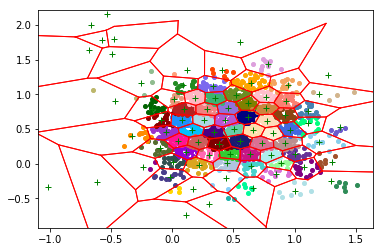

segment: 2


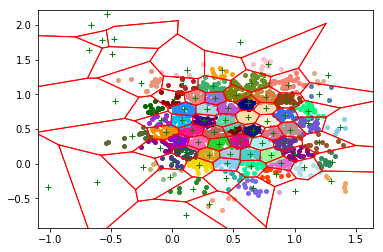

In [8]:
# -------------------------------------------------------------------------------------------------
# tessellating and segmenting with a sliding time window (NOT prepared for temporal regularization)
# -------------------------------------------------------------------------------------------------

## key parameters
# window duration in s
window_duration = 1.
# window overlap
window_overlap = 0.5 # 50%

## load the translocation data
xyt = load_default_trajectories(time_varying_properties=True)

## segment
cells = tessellate(xyt, 'kmeans', prune=False, time_window_duration=window_duration,
        time_window_shift=window_duration*(1.-window_overlap))
# notes: any spatial tessellation algorithm can be substituted to kmeans.
#        `prune` is kmeans-specific.

## plot a single segment
segment_index = 1 # ranges from 0
print('segment: {}'.format(segment_index))
cell_plot(cells, segment=segment_index)
segment_index = 2 # ranges from 0
print('segment: {}'.format(segment_index))
cell_plot(cells, segment=segment_index)

segment: 1


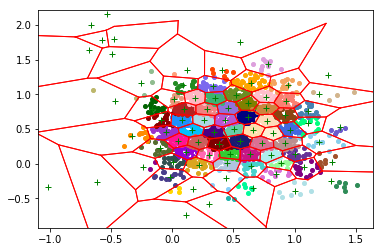

segment: 2


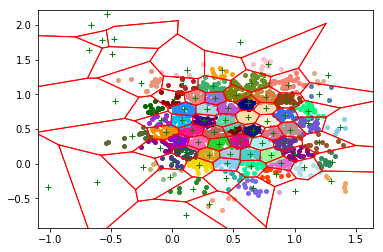

In [9]:
# ---------------------------------------------------------------------------------------------
# tessellating and segmenting with a sliding time window (prepared for temporal regularization)
# ---------------------------------------------------------------------------------------------

## key parameters
# window duration in s
window_duration = 1.
# window overlap
window_overlap = 0.5 # 50%

## load the translocation data
xyt = load_default_trajectories(time_varying_properties=True)

## segment
cells = tessellate(xyt, 'kmeans', prune=False, time_window_duration=window_duration,
        time_window_shift=window_duration*(1.-window_overlap),
        time_window_options=dict(time_dimension=True))
# notes: any spatial tessellation algorithm can be substituted to kmeans.
#        `prune` is kmeans-specific.

## plot a single segment
segment_index = 1 # ranges from 0
print('segment: {}'.format(segment_index))
cell_plot(cells, segment=segment_index)
segment_index = 2 # ranges from 0
print('segment: {}'.format(segment_index))
cell_plot(cells, segment=segment_index)

loading: tramway.inference.nT_test02...	[failed]
Traceback (most recent call last):
  File "/Users/cvesterg/ownCloud/Random walks/TRamWAy/TRamWAy/tramway/core/plugin.py", line 48, in list_plugins
    module = importlib.import_module(path)
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1005, in get_code
  File "<frozen importlib._bootstrap_external>", line 458, in _classify_pyc
ImportError: bad magic number in 'tramway.inference

/Users/cvesterg/ownCloud/Random walks/TRamWAy/TRamWAy/tramway/inference/base.py:212: PendingDeprecationWarning: `localization_error` may become sigma square in the coming 0.4 release, instead of sigma; please use `sigma` or `sigma2` to disambiguate
  warn('`localization_error` may become sigma square in the coming 0.4 release, instead of sigma; please use `sigma` or `sigma2` to disambiguate', PendingDeprecationWarning)
/Users/cvesterg/ownCloud/Random walks/TRamWAy/TRamWAy/tramway/inference/base.py:2378: RankWarning: The fit may be poorly conditioned
  _, b, a = poly.polyfit(x, y, 2)


At X0	actual posterior= -3306.8678505088965

dv mode: elapsed time: 1816540ms


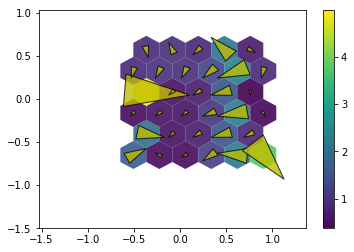

In [10]:
# ------------------------------------------------
# inferring in DV mode with spatial regularization
# ------------------------------------------------

## key parameters
# smoothing parameters
diffusivity_smoothing = potential_smoothing = 1.
# localization error in um
localization_error = 0.01

## load the partition
cells = load_default_partition()

## infer
maps = infer(cells, 'DV',
        diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing,
        localization_error=localization_error, verbose=True)

## plot the force
map_plot(maps, cells=cells, title=False, variable='force')
# other variables are 'diffusivity' and 'potential'

the stochastic_inference code is needed. In the TRamWAy source repository, type:

   git checkout stochastic_inference

and then restart the notebook's kernel and run the 'prerequisite' cell again.

you can hit Ctrl+C to stop the inference before convergence; maps will be generated anyway


/usr/local/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/Users/cvesterg/ownCloud/Random walks/TRamWAy/TRamWAy/tramway/inference/stochastic_dv.py:166: RuntimeWarning: invalid value encountered in log
  raw_posterior = n * log(pi) + np.sum(np.log(denominator)) + np.sum(ndsd / denominator)
/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:339: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return np.matrix(result, copy=False)


segment: 0
segment: 1
segment: 2
segment: 3
segment: 4


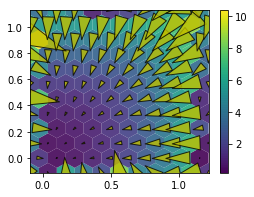

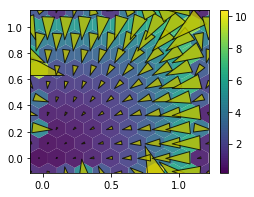

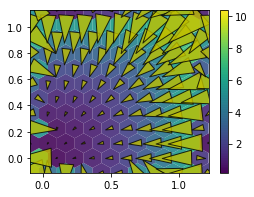

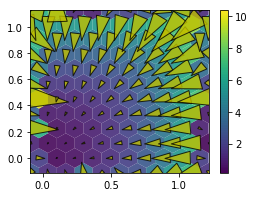

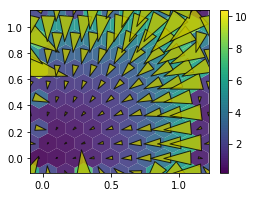

In [ ]:
# ------------------------------------------------------------
# inferring in stochastic DV mode with temporal regularization
# ------------------------------------------------------------

print('the stochastic_inference code is needed. In the TRamWAy source repository, type:')
print()
print('   git checkout stochastic_inference')
print()
print("and then restart the notebook's kernel and run the 'prerequisite' cell again.")
print()

from tramway.inference.time import *

## key parameters
# spatial smoothing parameters
diffusivity_smoothing = potential_smoothing = 1.
# temporal smoothing parameter
time_smoothing = 1.
# localization error in um
localization_error = 0.01

## load the partition
cells = load_default_partition(time_varying_properties=True)

## infer
print('you can hit Ctrl+C to stop the inference before convergence; maps will be generated anyway')
maps = infer(cells, 'stochastic.dv',
        new_cell=DynamicTranslocations, new_group=DynamicCells,
        diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing,
        time_prior=time_smoothing,
        localization_error=localization_error,
        gtol=1e-3)

## plot the force
number_of_segments = len(cells.tessellation.time_lattice)
for segment in range(number_of_segments):
    
    print('segment: {}'.format(segment))
    map_plot(maps, cells, segment=segment, show=False, title=False, figsize=(4,3), variable='force')
    # other variables are 'diffusivity' and 'potential'


/Users/cvesterg/ownCloud/Random walks/TRamWAy/TRamWAy/tramway/inference/base.py:212: PendingDeprecationWarning: `localization_error` may become sigma square in the coming 0.4 release, instead of sigma; please use `sigma` or `sigma2` to disambiguate
  warn('`localization_error` may become sigma square in the coming 0.4 release, instead of sigma; please use `sigma` or `sigma2` to disambiguate', PendingDeprecationWarning)
/Users/cvesterg/ownCloud/Random walks/TRamWAy/TRamWAy/tramway/inference/base.py:2378: RankWarning: The fit may be poorly conditioned
  _, b, a = poly.polyfit(x, y, 2)


print(analyses)
<class 'pandas.core.frame.DataFrame'>
	'default' <class 'tramway.tessellation.base.CellStats'>
		'default' <class 'tramway.inference.base.Maps'>
		'D mode' <class 'tramway.inference.base.Maps'>
			'Bayes factors' <class 'tramway.inference.base.Maps'>


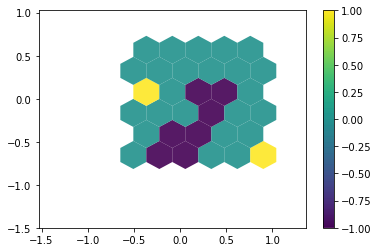

In [ ]:
# ----------------------------------------------------------
# calculating Bayes factors on the forces inferred in D mode
# ----------------------------------------------------------

## key parameters
# localization error in um
localization_error = 0.01

# labels
partition_label = 'default' # do NOT modify
model_label = 'D mode' # can be any integer or string value
bayes_factor_label = 'Bayes factors' # idem

## load the analysis tree
analyses = load_default_tree()
# the structure is:
# --> default trajectories
#  +--> default partition
#    +--> (possibly) default maps

## infer
# D mode with the SNR extensions required by the bayes_factor plugin
infer(analyses, 'd.snr', localization_error=localization_error,
     input_label=partition_label, output_label=model_label)
# the structure now is:
# --> default trajectories
#  +--> default partition
#    +...
#    +--> D-mode maps

# Bayes factors
infer(analyses, 'bayes_factor', localization_error=localization_error*localization_error,
     input_label=(partition_label, model_label), output_label=bayes_factor_label)
# the structure now is:
# --> default trajectories
#  +--> default partition
#    +...
#    +--> D-mode maps
#      +--> Bayes factor maps

## check the structure of the analysis tree
print('print(analyses)')
print(analyses)

## plot the force detection map
map_plot(analyses, label=(partition_label, model_label, bayes_factor_label), title=False, variable='force')


In [ ]:
# ------------------------------------
# building and saving an analysis tree
# ------------------------------------

# preliminary: if trajectory_file does not exist, generate it
if not os.path.exists(trajectory_file):
    load_default_trajectories()

# load trajectory_file
trajs = load_xyt(trajectory_file)

# the (trans-)location data is the top node of the analysis tree
analysis_tree = Analyses(trajs)

print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
print()

# partition the locations into space cells
hexagonal_cells = tessellate(trajs, 'hexagon')

# the partition is a first analysis; let's append it below trajs with label 'hexagonal mesh'
analysis_tree.add(hexagonal_cells, label='hexagonal mesh')

# the two lines above could be combined the following way:
#hexagonal_cells = tessellate(analysis_tree, 'hexagon', label='hexagonal mesh')

print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
#	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
print()

# make another partition
random_cells = tessellate(trajs, 'random', cell_count=100)

# ...and add it to the analysis_tree below trajs with label 'random mesh'
analysis_tree.add(random_cells, label='random mesh')

# similarly, the two lines above could be combined the following way:
#random_cells = tessellate(analysis_tree, 'random', cell_count=100, label='random mesh')

print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
#	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
#	'random mesh' <class 'tramway.tessellation.base.CellStats'>
print()

# infer in D mode with random_cells
random_maps = infer(random_cells, 'D', sigma=0.01) # sigma = positioning error

# add the inferred maps below 'random mesh' with label 'D'
analysis_tree['random mesh'].add(random_maps, label='D')

# again, the two lines above could be combined the following way:
#random_maps = infer(analysis_tree, 'D', sigma=0.01, input_label='random mesh', output_label='D')

print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
#	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
#	'random mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
print()

# infer in D mode with snr extensions (for the bayes_factors plugin) and hexagonal_cells
hexagonal_maps = infer(hexagonal_cells, 'd.snr', sigma=0.01)

# add the inferred maps below 'hexagonal mesh' with label 'D' as well
analysis_tree['hexagonal mesh'].add(hexagonal_maps, label='D')

print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
#	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
#	'random mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
print()

# compute the Bayes factor on these latter "maps"
bayes_factors = infer(analysis_tree, 'bayes_factor', sigma=0.01, input_label=('hexagonal mesh', 'D'), output_label='Bayes factors')
# here, the analysis tree is readily updated

print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
#	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
#			'Bayes factors' <class 'tramway.inference.base.Maps'>
#	'random mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
print()

# save the analyses
save_rwa('my_analyses.rwa', analysis_tree)


print(analysis_tree)
<class 'pandas.core.frame.DataFrame'>

print(analysis_tree)
<class 'pandas.core.frame.DataFrame'>
	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>

print(analysis_tree)
<class 'pandas.core.frame.DataFrame'>
	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
	'random mesh' <class 'tramway.tessellation.base.CellStats'>

print(analysis_tree)
<class 'pandas.core.frame.DataFrame'>
	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
	'random mesh' <class 'tramway.tessellation.base.CellStats'>
		'D' <class 'tramway.inference.base.Maps'>

print(analysis_tree)
<class 'pandas.core.frame.DataFrame'>
	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
		'D' <class 'tramway.inference.base.Maps'>
	'random mesh' <class 'tramway.tessellation.base.CellStats'>
		'D' <class 'tramway.inference.base.Maps'>



/usr/local/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


print(analysis_tree)
<class 'pandas.core.frame.DataFrame'>
	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
		'D' <class 'tramway.inference.base.Maps'>
			'Bayes factors' <class 'tramway.inference.base.Maps'>
	'random mesh' <class 'tramway.tessellation.base.CellStats'>
		'D' <class 'tramway.inference.base.Maps'>



In [ ]:
# -------------------------------------
# loading and browsing an analysis tree
# -------------------------------------

# load
analysis_tree = load_rwa('my_analyses.rwa')

# print the tree structure
print('print(analysis_tree)')
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>
#	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
#			'Bayes factors' <class 'tramway.inference.base.Maps'>
#	'random mesh' <class 'tramway.tessellation.base.CellStats'>
#		'D' <class 'tramway.inference.base.Maps'>
print()

# retrieve some data
trajs = analysis_tree.data
hexagonal_cells = analysis_tree['hexagonal mesh'].data
hexagonal_maps = analysis_tree['hexagonal mesh']['D'].data
#...

# print a subtree
print("print(analysis_tree)['random mesh'])")
print(analysis_tree['random mesh'])
#<class 'tramway.tessellation.base.CellStats'>
#	'D' <class 'tramway.inference.base.Maps'>
print()

# print some data
print("print(analysis_tree)['random mesh'].data)")
print(analysis_tree['random mesh'].data)
#location_count:  None
#@time_window:    duration:           1.0
#                 shift:              1.0
#                 time_dimension:     True
#@upper_bound:    [ 1.1  1.1]
#cell_index:      <class 'numpy.ndarray'>
#@partition:      metric:             euclidean
#                 knn:                10
#@method:         random
#bounding_box:    None
#@cell_count:     100
#points:          <class 'pandas.core.frame.DataFrame'>
#tessellation:    <class 'tramway.tessellation.random.RandomMesh'>
#@lower_bound:    [-0.1 -0.1]
#number_of_cells: 100
#@tessellation:   cell_count:         100
#                 avg_probability:    0.033927056827820185
#                 avg_location_count: 80
print()

print("print(analysis_tree)['random mesh']['D'].data)")
print(analysis_tree['random mesh']['D'].data)
#mode:      d
#maps:      <class 'pandas.core.frame.DataFrame'>
#sigma:     0.01
#runtime:   0.11431741714477539
#variables: ['diffusivity']
print()


In [ ]:
4*0.2*0.04